In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile, lcl_temp_bolton, lcl_sigma_bolton_simple
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure, \
    get_var_at_plev, get_ds_in_pressure_range
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx, fitting_2_layer_xr
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical, get_temp_mod_parcel
from isca_tools.utils.decomposition import pca_on_xarray
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_temp_adiabat_surf, get_temp_adiabat
from isca_tools.thesis.profile_fitting import get_mse_env, get_tropopause_lev_ind, get_mse_prof_rms
from isca_tools.utils.ds_slicing import lat_lon_coord_slice
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

from isca_tools.utils.xarray import flatten_to_numpy, unflatten_from_numpy, convert_ds_dtypes
from isca_tools.papers.byrne_2021 import get_quant_ind

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [3]:
load_from_file = True
if load_from_file:
    from jobs.theory_lapse.isca.load_ds_quant import ds_quant, region, hemisphere, season

Loaded /Users/joshduffield/Desktop/ds_isca_quant_dailymax.nc


In [4]:
# Info for loading in data
if not load_from_file:
    exp_dir = {'aquaplanet': 'tau_sweep/aquaplanet/depth=1/'}
    kappa_names = ['k=1_2m', 'k=1_5_2m']
    # kappa_names = ['k=1_2m']
    # kappa_names = ['k=1_5_2m']
    n_kappa = len(kappa_names)

    region = 'tropics'
    hemisphere = 'north'
    season = 'summer'
    lat_min = 0
    lat_max = 20
    # lat_max = 4

    if hemisphere == 'north':
        lat_min = np.abs(lat_min)
        lat_max = np.abs(lat_max)
    else:
        lat_min = -np.abs(lat_max)
        lat_max = -np.abs(lat_min)

    season_months = {'summer': {'tropics': {'north': [5, 6, 7, 8, 9, 10],
                                            'south': [11, 12, 1, 2, 3, 4]},
                                'not_tropics': {'north': [6, 7, 8],
                                                'south': [12, 1, 2]}},
                     'winter': {}}
    for key in ['tropics', 'not_tropics']:
        season_months['winter'][key] = {'north': season_months['summer'][key]['south'],
                                        'south': season_months['summer'][key]['north']}

    # Load dataset - one at surface and one in free troposphere
    var_keep = ['temp', 'sphum', 'height', 'cape',
                'ps']  # only keep variables required to compute relative humidity and MSE
    use_time_start = 360 * 2

### Convert ds to CESM like data
Below I convert the variable names in the dataset into those expected from CESM.

In [5]:
if not load_from_file:
    ds = {key: [] for key in exp_dir}
    albedo = {key: [] for key in exp_dir}
    tau_sw = {key: [] for key in exp_dir}
    tau_lw = {key: [] for key in exp_dir}
    with tqdm(total=n_kappa, position=0, leave=True) as pbar:
        for key in exp_dir:
            for j in range(n_kappa):
                ds_use = isca_tools.load_dataset(exp_dir[key] + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[
                    var_keep]
                ds_use['sphum'] = ds_use.sphum.isel(pfull=-1)  # only keep surface SPHUM

                ds_use = ds_use.sel(lat=slice(lat_min, lat_max))
                # Only keep land longitudes - for aquaplanet, does not matter which we keep
                # ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])

                # Only load in months of interest for season and hemisphere
                ds_use = isca_tools.utils.annual_time_slice(ds_use, season_months[season][region][hemisphere])
                # Stack longitude and time into new sample dimension to match CESM
                # ds_use = ds_use.stack(sample=("lon", "time"), create_index=False).chunk(dict(sample=-1))
                ds[key] += [ds_use.load()]

                namelist = isca_tools.load_namelist(exp_dir[key] + kappa_names[j])  # Need this for albedo_value
                albedo[key] += [namelist['mixed_layer_nml']['albedo_value']]
                tau_sw[key] += [namelist['two_stream_gray_rad_nml']['atm_abs']]
                tau_lw[key] += [namelist['two_stream_gray_rad_nml']['odp']]
                pbar.update(1)
            ds[key] = xr.concat(ds[key], dim=xr.DataArray(tau_lw[key], dims="tau_lw", name='tau_lw'))

    # Concatenate ds along surf dimension
    ds = xr.concat([ds[key] for key in ds],
                   dim=xr.DataArray([key for key in ds], dims="surf", name='surf'))

    # Rename variables to match CESM
    ds = ds.rename({'temp': 'T', 'sphum': 'QREFHT',
                    'height': 'Z3', 'cape': 'CAPE', 'ps': 'PS',
                    'pfull': 'lev'})

    # sigma_half reflects ds_us.pfull (starts with 0 - space, ends with 1 - surface)
    sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
    # hybm are sigma full levels
    hybm = np.convolve(sigma_levels_half, np.ones(2) / 2,
                       'valid')  # sigma levels corresponding to pressure levels
    ds['hybm'] = ds.lev * 0 + hybm  # convert to xarray

    # choose lowest model level as REFHT
    ds['TREFHT'] = ds.T.isel(lev=-1)
    # ds['ZREFHT'] = ds.Z3.isel(lev=-1)
    ds['PREFHT'] = ds.PS * ds.hybm.isel(lev=-1)

### Compute variables for lapse fitting
Below, I compute the LCL and FT variables required to do the vertical temperature profile fitting.

In [6]:
def get_P(ds):
    return ds.PS * ds.hybm

if load_from_file:
    p_ft = ds_quant.p_ft
else:
    p_ft = 500 * 100
    ds['rh_REFHT'] = ds.QREFHT / sphum_sat(ds.TREFHT, ds.PREFHT)
    ds['T_ft_env'] = get_var_at_plev(ds.T, get_P(ds), p_ft)

## Analysis as function of temperature quantile, $x$
Next, for a range of `TREFHT` quantiles, I first get the `ds` conditioned on these temperatures.

Then I compute the parameters and error for the `const` and `mod_parcel` lapse rate profiles on these sample days.

In [7]:
def get_ds_quant_single_coord(ds, quant=90, range_below=0.5, range_above=0.5):
    quant_mask = get_quant_ind(ds.TREFHT.squeeze(), quant, range_below, range_above, av_dim=['lon', 'time'],
                               return_mask=True)
    ds_use = ds.where(quant_mask).stack(sample=("lon", "time"), create_index=False).chunk(dict(sample=-1))
    ds_use = ds_use.load()
    ds_use = ds_use.where(ds_use.TREFHT > 0, drop=True)
    return ds_use


def get_ds_quant(ds, quant=90, range_below=0.5, range_above=0.5, n_keep=None):
    quant_mask = get_quant_ind(ds.TREFHT, quant, range_below, range_above, av_dim=['lon', 'time'], return_mask=True)
    # n_keep is so can concat ds of different quantiles. A given quant range will give slightly different numbers of samples at each location.
    # Through providing n_keep, you can ensure the number is always the same.
    n_keep_max = int(quant_mask.sum(dim=['lon', 'time']).min())
    if n_keep is None:
        n_keep = n_keep_max
    if n_keep > n_keep_max:
        raise ValueError(f'n_keep={n_keep} > n_keep_max={n_keep_max}')
    ds_out = []
    for i in range(ds.tau_lw.size):
        ds_use_j = []
        for j in range(ds.surf.size):
            ds_use_k = []
            for k in range(ds.lat.size):
                ds_use_k.append(
                    get_ds_quant_single_coord(ds.isel(tau_lw=i, surf=j, lat=k, drop=True), quant, range_below,
                                              range_above).isel(sample=slice(0, n_keep)))
            ds_use_k = xr.concat(ds_use_k, dim=ds.lat)
            ds_use_j.append(ds_use_k)
        ds_use_j = xr.concat(ds_use_j, dim=ds.surf)
        ds_out.append(ds_use_j)
    ds_out = xr.concat(ds_out, dim=ds.tau_lw)
    return ds_out

In [8]:
if not load_from_file:
    quant_range = 0.5
    n_sample = 180
    n_sample = None  # get all
    n_sample = 600
    # n_sample = 10
    quant_all = np.arange(1, 100, 3)
    ds_quant = []
    for i in tqdm(quant_all):
        ds_quant.append(get_ds_quant(ds, i, quant_range, quant_range, n_sample))
    if n_sample is None:
        n_sample = np.min([i.sample.size for i in ds_quant])
        # Ensure all have same size
        ds_quant = [i.isel(sample=slice(0, n_sample)) for i in ds_quant]
    ds_quant = xr.concat(ds_quant, dim=xr.DataArray(quant_all, dims="quant", name='quant'))

In [9]:
if load_from_file:
    temp_lcl_bolton_use = ds_quant.temp_surf_lcl_calc
else:
    temp_lcl_bolton_use = float(np.ceil(ds.TREFHT.median()))


# def get_lapse_fitting_info(ds):
#     ds.attrs['n_lev_above_integral'] = 3
#     var_names = ['lapse', 'integral', 'error']
#
#     with tqdm(total=2, position=0, leave=True) as pbar:
#         for key in ['const', 'mod_parcel']:
#             var = fitting_2_layer_xr(ds.T, get_P(ds), ds.TREFHT, ds.PREFHT, ds.rh_REFHT, ds.T_ft_env,
#                                      p_ft, n_lev_above_upper2_integral=ds.n_lev_above_integral,
#                                      method_layer2=key, temp_surf_lcl_calc=temp_lcl_bolton_use)
#             # Must include fillna as inf to deal with all nan slice.
#             for k, key2 in enumerate(var_names):
#                 ds[f'{key}1_{key2}'] = var[k]
#             pbar.update(1)
#     return ds

def get_lapse_fitting_info(ds: xr.Dataset):
    """Compute lapse fitting diagnostics for each quant, returning ds with added vars.

    Args:
        ds (xr.Dataset): Input dataset with dimension 'quant'.

    Returns:
        xr.Dataset: Dataset with computed lapse-fitting fields for each quant.
    """
    ds.attrs["n_lev_above_integral"] = 3
    var_names = ["lapse", "integral", "error"]
    keys = ["const", "mod_parcel"]

    quants = ds["quant"].values
    out_list = []

    with tqdm(total=len(quants), position=0, leave=True) as pbar:
        for q in quants:
            small = {}

            for key in keys:
                var = fitting_2_layer_xr(
                    ds.T.sel(quant=q),
                    get_P(ds).sel(quant=q),
                    ds.TREFHT.sel(quant=q),
                    ds.PREFHT.sel(quant=q),
                    ds.rh_REFHT.sel(quant=q),
                    ds.T_ft_env.sel(quant=q),
                    p_ft,
                    n_lev_above_upper2_integral=ds.n_lev_above_integral,
                    method_layer2=key,
                    temp_surf_lcl_calc=temp_lcl_bolton_use,
                )

                for k, name in enumerate(var_names):
                    # Build variable name such as "const1_lapse"
                    vname = f"{key}1_{name}"
                    small[vname] = var[k].expand_dims(quant=[q])

            # One small dataset per q
            out_list.append(xr.Dataset(small))

            pbar.update(1)

    # Concatenate all per-quant datasets
    new_vars = xr.concat(out_list, dim="quant")

    # Merge into original ds
    return xr.merge([ds, new_vars])

In [10]:
if not load_from_file:
    ds_quant = get_lapse_fitting_info(ds_quant)

### Error in Fitting
Below we see that the coldest days have quite a large error, and often more than the `const_lapse` fitting. We exclude these from the subsequent analysis on breaking down the scaling factor into individual mechanisms.

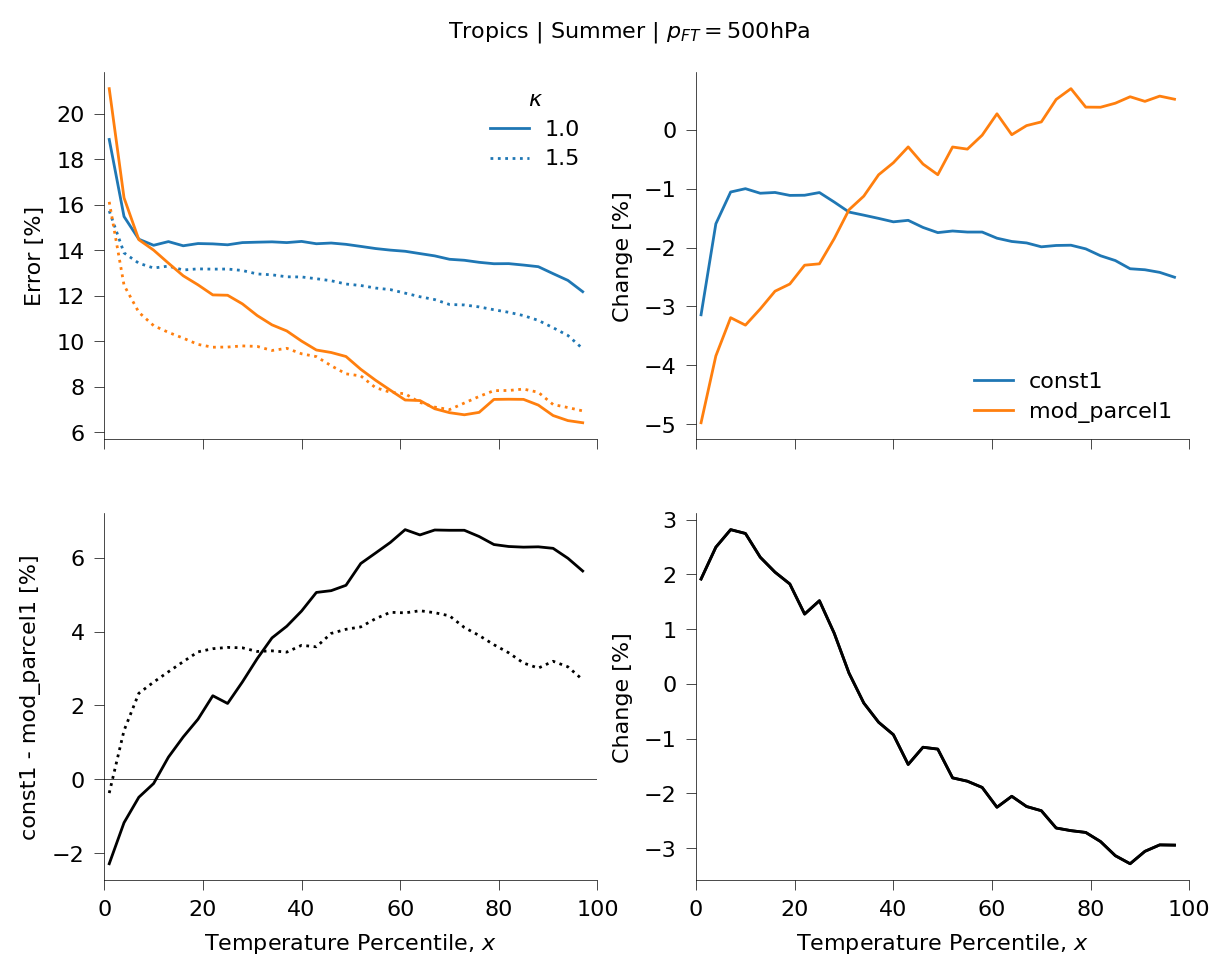

In [11]:
lat_weights = np.cos(np.deg2rad(ds_quant.lat))
percentile_label = 'Temperature Percentile, $x$'

fig, ax = plt.subplots(2, 2, sharex=True)
fig_resize(fig, 7)
var = {}
for j, key in enumerate(['const1', 'mod_parcel1']):
    var[key] = np.abs(
        ds_quant[f'{key}_error'].sum(dim='layer') / ds_quant[f'{key}_integral'].sum(dim='layer') * 100).isel(surf=0)
    for i in range(ds_quant.tau_lw.size):
        ax[0, 0].plot(ds_quant.quant,
                      np.average(var[key].isel(tau_lw=i).quantile(0.5, dim='sample'), axis=1, weights=lat_weights),
                      linestyle=':' if i == 1 else None, color=f"C{j}",
                      label=f"{ds_quant.tau_lw.values[i]:.1f}" if j == 0 else None)
    ax[0, 1].plot(ds_quant.quant, np.average(var[key].isel(tau_lw=1).quantile(0.5, dim='sample') -
                                             var[key].isel(tau_lw=0).quantile(0.5, dim='sample'), axis=1,
                                             weights=lat_weights),
                  color=f"C{j}", label=key)
var = var['const1'] - var['mod_parcel1']
for i in range(ds_quant.tau_lw.size):
    ax[1, 0].plot(ds_quant.quant,
                  np.average(var.isel(tau_lw=i).quantile(0.5, dim='sample'), axis=1, weights=lat_weights),
                  linestyle=':' if i == 1 else None, color=f"k")
    ax[1, 1].plot(ds_quant.quant, np.average(var.isel(tau_lw=1).quantile(0.5, dim='sample') -
                                             var.isel(tau_lw=0).quantile(0.5, dim='sample'), axis=1,
                                             weights=lat_weights), color=f"k")
update_linewidth(fig)
ax[0, 0].set_ylabel('Error [%]')
ax[0, 0].legend(title='$\kappa$')
ax[0, 1].set_ylabel('Change [%]')
ax[0, 1].legend()
ax[1, 0].set_ylabel('const1 - mod_parcel1 [%]')
ax[1, 0].axhline(0, lw=ax_linewidth, color='k')
ax[1, 1].set_ylabel('Change [%]')
fig.suptitle(f"{region.capitalize()} | {season.capitalize()} | "
             f"$p_{'{FT}'} = {p_ft / 100:.0f}$hPa", y=0.93)
ax[0, 0].set_xlim(0, 100)
ax[1, 0].set_xlabel(percentile_label)
ax[1, 1].set_xlabel(percentile_label)
update_fontsize(fig)
plt.show()

In [12]:
ds_sf = ds_quant[['TREFHT', 'PREFHT', 'rh_REFHT', 'T_ft_env', 'mod_parcel1_lapse']].isel(surf=0)
error = {
    key: np.abs(ds_quant[f'{key}1_error'].sum(dim='layer') / ds_quant[f'{key}1_integral'].sum(dim='layer') * 100).isel(
        surf=0)
    for key in ['mod_parcel', 'const']}
mask_use = (error['mod_parcel'] < 25) & (error['mod_parcel'] < error['const'])
# mask_use = mask_use * 0 + 1
ds_sf = ds_sf.where(mask_use).mean(dim='sample')
ds_sf['lapse_mod_D'] = ds_sf['mod_parcel1_lapse'].isel(layer=0) / 1000 - lapse_dry
ds_sf['lapse_mod_M'] = ds_sf['mod_parcel1_lapse'].isel(layer=1) / 1000
ds_sf = ds_sf.drop_vars('mod_parcel1_lapse')
ds_sf = ds_sf.transpose('tau_lw', 'quant', 'lat')
ds_sf = ds_sf.rename({'TREFHT': 'temp_surf', 'PREFHT': 'p_surf', 'rh_REFHT': 'rh_surf', 'T_ft_env': 'temp_ft',
                      'tau_lw': 'co2'})
for key in ['temp_surf', 'p_surf', 'rh_surf', 'lapse_mod_D', 'lapse_mod_M']:
    ds_sf[key + '_ref'] = ds_sf[key].median(dim='quant')
    if 'lapse' in key:
        ds_sf[key + '_ref'] = np.abs(ds_sf[key + '_ref'] * 0)  # for lapse, ref value is 0
    elif key != 'temp_surf':
        # For rh and pressure, keep at colder climate ref
        ds_sf[key + '_ref'] = ds_sf[key + '_ref'] * 0 + ds_sf[key + '_ref'].isel(co2=0)

### Fraction of days used
In the scaling factor computation, we only include days for which the vertical `mod_parcel1` profile is good. We define *good* as having the error less than 25% and having a smaller error than the `const1` method.

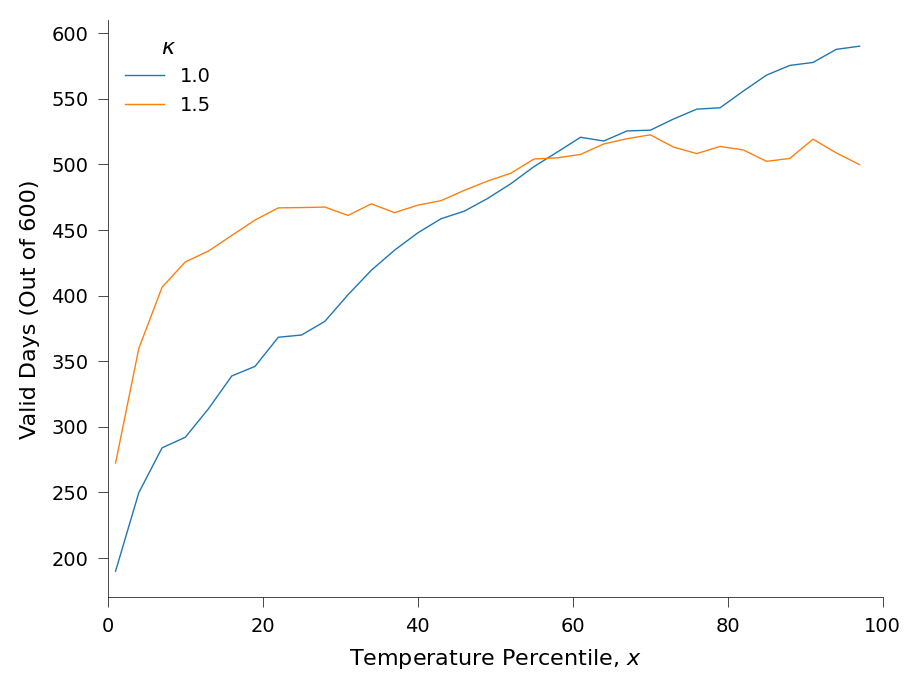

In [13]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
for i in range(ds_quant.tau_lw.size):
    ax.plot(ds_quant.quant, np.average(mask_use.sum(dim='sample').isel(tau_lw=i), axis=1, weights=lat_weights),
            label=f"{mask_use.tau_lw.values[i]:.1f}")
ax.set_xlabel(percentile_label)
ax.set_ylabel(f"Valid Days (Out of {ds_quant.sample.size:.0f})")
ax.set_xlim(0, 100)
ax.legend(title='$\kappa$')
plt.show()

### Scale Factor Breakdown
Now, we compute the breakdown of the scaling factor into all the different physical mechanisms using a numerical method.

We include a linear and non-linear contribution for each mechanism. These are combined unless `show_non_linear=True`. The linear mechanism is really the best we can hope for once we make all the taylor series approximations.

In [16]:
def apply_scale_factor(ds, p_ft=p_ft):
    """Apply get_scale_factor_theory_numerical to an xarray.Dataset."""

    out_main, out_linear, out_dict = xr.apply_ufunc(
        get_scale_factor_theory_numerical,
        ds["temp_surf_ref"],  # (co2)
        ds["temp_surf"],  # (co2, quant)
        ds["rh_surf_ref"],  # (co2)
        ds["rh_surf"],  # (co2, quant)
        ds["temp_ft"],  # (co2, quant)
        ds["lapse_mod_D"],  # (co2, quant)
        ds["lapse_mod_M"],  # (co2, quant)
        p_ft,  # (co2) or scalar
        ds["p_surf_ref"],  # (co2) or scalar
        ds["p_surf"],  # (co2, quant) or None
        ds["lapse_mod_D_ref"],  # (co2) or None
        ds["lapse_mod_M_ref"],  # (co2) or None
        kwargs=dict(
            temp_surf_lcl_calc=300,
            lapse_coords='z'
        ),
        input_core_dims=[
            ["co2"],  # temp_surf_ref
            ["co2", "quant"],
            ["co2"],
            ["co2", "quant"],
            ["co2", "quant"],
            ["co2", "quant"],
            ["co2", "quant"],
            [],  # p_ft_ref
            ["co2"],  # p_surf_ref
            ["co2", "quant"],
            ["co2"],
            ["co2"],
        ],
        output_core_dims=[
            ["quant"],  # result array
            ["quant"],
            []  # dict-of-arrays (broadcast to co2)
        ],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float, object],
    )

    # Expand the dictionary output entries into proper DataArrays
    dict_ds = {'scale_factor': (ds['temp_surf'].isel(co2=1) - ds['temp_surf'].isel(co2=0)
                                ) / (ds['temp_surf_ref'].isel(co2=1) - ds['temp_surf_ref'].isel(co2=0))}

    # Determine all dict keys from the first element
    dict_single_lat = out_dict.isel(lat=0).item()
    keys = list(dict_single_lat.keys())

    for key in keys:
        # Collect arrays across lat dimension
        stacked = []
        for i in range(out_dict.sizes["lat"]):
            arr = out_dict.isel(lat=i).item()[key]  # (quant,)
            stacked.append(arr)

        da = xr.DataArray(
            np.stack(stacked, axis=0),  # (lat, quant)
            dims=("lat", "quant"),
            coords={"lat": ds.lat, "quant": ds.quant},
        )
        dict_ds[key] = da

    ds_out = xr.Dataset({"scale_factor_sum": out_main, "scale_factor_linear": out_linear, **dict_ds})
    ds_out = ds_out.transpose("lat", "quant")
    return ds_out

In [17]:
style_map = {
    # --- reference change (dashed) ---
    "r_ref_change": ("C0", "--"),
    "p_surf_ref_change": ("C2", "--"),
    "lapse_mod_D_ref_change": ("C1", "--"),
    "lapse_mod_M_ref_change": ("C3", "--"),

    # --- change (solid) ---
    "temp_ft_change": ("C2", "-"),
    "r_change": ("C0", "-"),
    "lapse_mod_D_change": ("C1", "-"),
    "lapse_mod_M_change": ("C3", "-"),
    "p_surf_change": ("C1", "-"),
    "error_av_change": ("C5", "-"),

    # --- anomalies (dotted) ---
    "temp_anom": ("C2", ":"),
    "r_anom": ("C0", ":"),
    "lapse_mod_D_anom": ("C1", ":"),
    "lapse_mod_M_anom": ("C3", ":"),
    "p_surf_anom": ("C1", ":"),

    # nl
    "nl_residual": ("C5", "-."),

    # sf
    "scale_factor": ('k', "-"),
    "scale_factor_linear": ('k', ":"),
    "scale_factor_sum": ('k', "--")
}
for key2 in [k for k in style_map if "nl" not in k and "ref" not in k]:
    style_map['nl_' + key2] = (style_map[key2][0], '-.')

ds_out = apply_scale_factor(ds_sf)

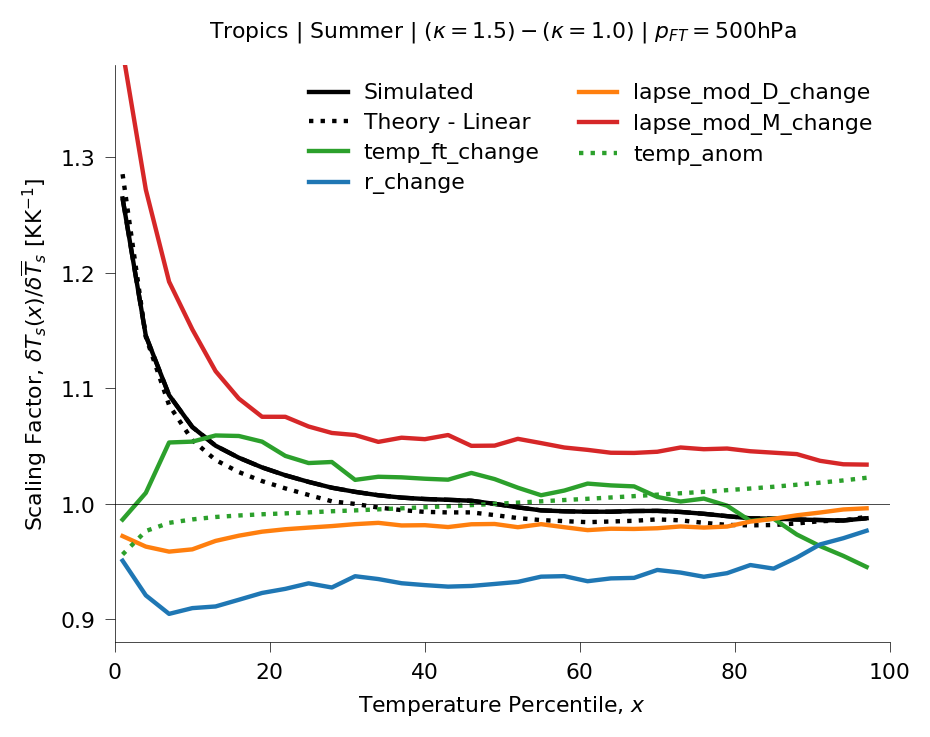

In [26]:
show_non_linear = False

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
for key in ['', '_sum', '_linear']:
    ax.plot(ds_out.quant, np.average(ds_out[f"scale_factor{key}"], axis=0, weights=lat_weights),
            color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
            label={'': 'Simulated', '_linear': 'Theory - Linear', '_sum': None}[key])
for key in ds_out:
    var = ds_out[key]
    if 'scale_factor' in key:
        continue
    elif 'nl' in key:
        # Combine non-linear and linear into single mechanism on plot
        if (not show_non_linear) and ('residual' not in key):
            var = var + ds_out[key.replace('nl_', '')] - 1
            key = key.replace('nl_', '')
    elif not show_non_linear:
        continue
    if np.average(np.abs(var - 1), axis=0, weights=lat_weights).max() < 0.02:
        continue
    ax.plot(ds_out.quant, np.average(var, axis=0, weights=lat_weights), label=key,
            color=style_map[key][0], linestyle=style_map[key][1])
update_linewidth(fig)
ax.legend(ncol=2)
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_ylabel("Scaling Factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]")
ax.set_title(
    f"{region.capitalize()} | {season.capitalize()} | $(\kappa = {ds_sf.co2.values[1]}) - (\kappa = {ds_sf.co2.values[0]})$ | "
    f"$p_{'{FT}'} = {p_ft / 100:.0f}$hPa", y=1.02)
update_fontsize(fig, 5)
ax.set_xlim(0, 100)
ax.set_ylim(0.88, 1.38)
plt.show()

### Principle Component Analysis
Playing around to see how to visualize `sample` dimension.

In [17]:
from typing import Callable, Any, Sequence
def wrap_with_apply_ufunc(
    func: Callable,
    input_core_dims: Optional[Sequence[Sequence[str]]] = None,
    output_core_dims: Optional[Sequence[Sequence[str]]] = None,
    dask: str = "parallelized",
    vectorize: bool = True,
    **ufunc_kwargs: Any,
) -> Callable:
    """Wrap a function for use with xarray.apply_ufunc.

    Args:
        func: The function to wrap.
        output_core_dims: Core dimensions produced by the function. Defaults
            to ``[[]]`` for a single scalar-like output.
        dask: Dask handling mode.
        vectorize: Whether to auto-vectorize over non-core dims.
        **ufunc_kwargs: Extra apply_ufunc keyword arguments.

    Returns:
        A callable that behaves like ``func`` but operates on xarray objects.
    """

    def wrapped(*args: Any, **kwargs: Any):
        # Default: one empty core-dim list for each input argument
        if input_core_dims is None:
            input_core = [[] for _ in args]
        else:
            input_core = input_core_dims

        # Default: one empty core-dim list for the function output
        output_core = output_core_dims if output_core_dims is not None else [[]]

        return xr.apply_ufunc(
            func,
            *args,
            input_core_dims=input_core,
            output_core_dims=output_core,
            dask=dask,
            vectorize=vectorize,
            kwargs=kwargs,
            **ufunc_kwargs,
        )

    return wrapped
get_temp_mod_parcel_xr = wrap_with_apply_ufunc(get_temp_mod_parcel)

In [18]:
ds_pca = ds_quant[['PREFHT', 'rh_REFHT', 'T_ft_env', 'mod_parcel1_lapse']].isel(surf=0)
ds_pca['lapse_mod_D'] = ds_pca.mod_parcel1_lapse.isel(layer=0) / 1000 - lapse_dry
ds_pca['lapse_mod_M'] = ds_pca.mod_parcel1_lapse.isel(layer=1) / 1000
ds_pca = ds_pca.drop_vars(['mod_parcel1_lapse'])
ref_vals = {key: ds_pca[key].where(mask_use).mean(dim=['quant', 'sample']) for key in ds_pca}
# ref_vals = {key: ds_pca[key].where(mask_use).isel(tau_lw=0).mean(dim=['quant', 'sample']) for key in ['PREFHT', 'rh_REFHT']}
# ref_vals['lapse_mod_D'] = ref_vals['PREFHT'] * 0
# ref_vals['lapse_mod_M'] = ref_vals['PREFHT'] * 0
ref_vals['TREFHT'] = ds_quant.TREFHT.isel(surf=0).where(mask_use).mean(dim=['quant', 'sample'])
ds_ref = xr.Dataset(ref_vals)
ds_ref['T_ft_env'] = get_temp_mod_parcel_xr(ref_vals['rh_REFHT'], ref_vals['PREFHT'], p_ft, ref_vals['lapse_mod_D'],
                                           ref_vals['lapse_mod_M'], ref_vals['TREFHT'], temp_surf_lcl_calc=temp_lcl_bolton_use)
for key in ds_pca:
    ds_pca[key] = ds_pca[key] - ds_ref[key]
# Make T_ft have same mean in both simulations

In [19]:
key1 = 'T_ft_env'
key2 = 'PREFHT'
for i in range(n_kappa):
    plt.scatter(ds_pca[key1].where(mask_use).isel(tau_lw=i),
                ds_pca[key2].where(mask_use).isel(tau_lw=i), s=1, marker='.', alpha=0.05)
# plt.scatter(ds_quant.mod_parcel1_lapse.isel(layer=0, tau_lw=1)-1*ds_quant.mod_parcel1_lapse.isel(layer=0, tau_lw=1).mean(),
#             ds_quant.T_ft_env.isel(tau_lw=1)-ds_quant.T_ft_env.isel(tau_lw=1).mean(), s=1, marker='.', alpha=0.5)

NameError: name 'n_kappa' is not defined

In [ ]:
pc_output = pca_on_xarray(xr.concat(list(ds_pca.values()), dim="feature"), n_modes=3, feature_dim_name="feature", valid=mask_use)
quant_use = slice(0, 200)
# lat_use = slice(0, 90)
# quant_use = -1
lat_use = -1
var = pc_output[1].where(mask_use).isel(quant=quant_use, lat=lat_use)

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
im = ax.scatter(var.isel(mode=0, tau_lw=0),
                var.isel(mode=1, tau_lw=0), marker='.', s=1,
                c=ds_quant.TREFHT.where(mask_use * 0 + 1).isel(tau_lw=0, quant=quant_use, lat=lat_use),
                alpha=0.3, label=var.tau_lw.values[0])
# im = ax.scatter(var.isel(mode=0, tau_lw=0),
#                 var.isel(mode=1, tau_lw=0), marker='.', s=1,
#                 c=var.isel(mode=2, tau_lw=0),
#                 alpha=0.3, label=var.tau_lw.values[0])
plt.colorbar(im, ax=ax)

# ax.scatter(var.isel(mode=0, tau_lw=0),
#            var.isel(mode=1, tau_lw=0), marker='.', s=1,
#            c='b', alpha=0.3, label=var.tau_lw.values[0])
# #
# ax.scatter(var.isel(mode=0, tau_lw=1),
#            var.isel(mode=1, tau_lw=1), marker='.', s=0.5,
#            c='y', alpha=0.3, label=var.tau_lw.values[1])


ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
# ax.set_title(f"Lat = {var.lat:.0f}$\degree$")
ax.legend(title='$\kappa$')
plt.show()


# plt.scatter(pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=0, lat=-1),
#             pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=1, lat=-1), marker='.', s=1, color='C1')

# quant_use = -1
# plt.scatter(pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=0, mode=0, lat=-1),
#             pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=0, mode=1, lat=-1), marker='x', s=5, color='C0')
# plt.scatter(pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=0, lat=-1),
#             pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=1, lat=-1), marker='x', s=5, color='C1')

# quant_use = -1
# plt.scatter(pc_output[1].where(mask_use.isel(lat=-1)).isel(quant=quant_use, tau_lw=0, mode=0),
#             pc_output[1].where(mask_use.isel(lat=-1)).isel(quant=quant_use, tau_lw=0, mode=1), marker='x', color='C0')
# plt.scatter(pc_output[1].where(mask_use.isel(lat=-1)).isel(quant=quant_use, tau_lw=1, mode=0),
#             pc_output[1].where(mask_use.isel(lat=-1)).isel(quant=quant_use, tau_lw=1, mode=1), marker='x', color='C1')
# plt.scatter(pc_output[1].isel(quant=0, tau_lw=1, mode=0), pc_output[1].isel(quant=0, tau_lw=1, mode=1))

In [ ]:
def get_temp_surf_from_pc(pc_x_coef, pc_y_coef, pc_eof=pc_output[0], pc_mean=pc_output[2], pc_std=pc_output[3], ds_ref=ds_ref.isel(lat=0, tau_lw=0),
                          pc_x_mode_ind=0, pc_y_mode_ind=2):
    # pc_coef should be n_mode x n_vals
    # pc_eof should be n_mode x n_feature
    # Returns n_pc1_coef x n_pc2_coef
    var = pc_x_coef[:, np.newaxis, np.newaxis] * pc_eof.isel(mode=pc_x_mode_ind).values[np.newaxis, np.newaxis]
    var = var + pc_y_coef[np.newaxis, : np.newaxis, np.newaxis] * pc_eof.isel(mode=pc_y_mode_ind).values[np.newaxis, np.newaxis]
    var = var * pc_std.values[np.newaxis, np.newaxis] + pc_mean.values[np.newaxis, np.newaxis]
    # var1 = pc1_coef[:, np.newaxis] * (pc_eof.isel(mode=0) * pc_std).values[np.newaxis]
    # var2 = pc2_coef[:, np.newaxis] * (pc_eof.isel(mode=1) * pc_std).values[np.newaxis]
    # var = var1[:, np.newaxis] + var2[np.newaxis]
    # var = var + pc_mean.values[np.newaxis, np.newaxis]
    p_surf = var[:, :, 0] + float(ds_ref['PREFHT'])
    rh_surf = var[:, :, 1] + float(ds_ref['rh_REFHT'])
    temp_ft_env = var[:, :, 2] + float(ds_ref['T_ft_env'])
    lapse_mod_D = var[:, :, 3] + float(ds_ref['lapse_mod_D'])
    lapse_mod_M = var[:, :, 4] + float(ds_ref['lapse_mod_M'])
    get_temp = np.vectorize(get_temp_mod_parcel)
    return get_temp(rh_surf, p_surf, p_ft, lapse_mod_D, lapse_mod_M, None, temp_ft_env, temp_lcl_bolton_use)


# print(get_temp_surf_from_pc(np.arange(-4, -3)*0, np.arange(-6, -5)*0-2))
pc_x_coef_plot = np.arange(-7, 7.5, 0.5)
pc_y_coef_plot = np.arange(-5, 5.5, 0.5)
temp_surf_pca_map = get_temp_surf_from_pc(pc_x_coef_plot, pc_y_coef_plot, pc_x_mode_ind=1, pc_y_mode_ind=0)
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig_resize(fig, 10)
im = ax[0].contourf(pc_x_coef_plot, pc_y_coef_plot, temp_surf_pca_map.T, levels=np.arange(288, 306, 2))
temp_surf_pca_map = get_temp_surf_from_pc(pc_x_coef_plot, pc_y_coef_plot, pc_x_mode_ind=2, pc_y_mode_ind=0)
im = ax[1].contourf(pc_x_coef_plot, pc_y_coef_plot, temp_surf_pca_map.T, levels=np.arange(288, 306, 2))
temp_surf_pca_map = get_temp_surf_from_pc(pc_x_coef_plot, pc_y_coef_plot, pc_x_mode_ind=2, pc_y_mode_ind=1)
im = ax[2].contourf(pc_x_coef_plot, pc_y_coef_plot, temp_surf_pca_map.T, levels=np.arange(288, 306, 2))
plt.colorbar(im, ax=ax, label='$T_s$ [K]')
ax[0].set_xlabel('PC2')
ax[0].set_ylabel('PC1')
ax[1].set_xlabel('PC3')
ax[2].set_ylabel('PC2')
ax[2].set_xlabel('PC3')
plt.show()

In [ ]:
from sklearn.cluster import KMeans


def cluster_pcs(pcs: xr.DataArray, n_clusters: int, mask: xr.DataArray) -> xr.DataArray:
    """Cluster PCA coefficients and return cluster labels for each sample.

    Args:
        pcs: PCA coefficients with dims (quant, tau_lw, lat, sample, mode).
        n_clusters: Number of clusters.

    Returns:
        DataArray of cluster labels with dimension 'sample'.
    """
    pcs_stacked = pcs.stack(point=("quant", "tau_lw", "lat", "sample"))
    mask_stacked = mask.stack(point=("quant", "tau_lw", "lat", "sample"))
    # Select only valid points

    X_train = (pcs_stacked.sel(point=mask_stacked).transpose("point", "mode").values)

    # Fit K-means on masked data only
    km = KMeans(n_clusters=n_clusters, n_init="auto")
    km.fit(X_train)

    X_full = pcs_stacked.transpose("point", "mode").values
    # assign clusters using all features
    labels = km.fit_predict(X_full)
    # unflatten_from_numpy(labels, pcs.isel(mode=0))
    return unflatten_from_numpy(labels, pcs.isel(mode=0))


labels = cluster_pcs(pc_output[1], 3, mask_use)

In [ ]:
(labels.where(mask_use).isel(quant=quant_use, lat=lat_use)==0)

In [ ]:
quant_use = slice(0, 200)
lat_use = slice(0, 90)
quant_use = 0
lat_use = -1
var = pc_output[1].where(mask_use).isel(quant=quant_use, lat=lat_use)

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
# im = ax.scatter(var.isel(mode=0, tau_lw=0),
#                 var.isel(mode=1, tau_lw=0), marker='.', s=1,
#                 c=ds_quant.TREFHT.where(mask_use * 0 + 1).isel(tau_lw=0, quant=quant_use, lat=lat_use),
#                 alpha=0.3, label=var.tau_lw.values[0])
# im = ax.scatter(var.isel(mode=0, tau_lw=0),
#                 var.isel(mode=1, tau_lw=0), marker='.', s=1,
#                 c=var.isel(mode=2, tau_lw=0),
#                 alpha=0.3, label=var.tau_lw.values[0])
im = ax.scatter(var.isel(mode=1, tau_lw=0),
                var.isel(mode=2, tau_lw=0), marker='.', s=1,
                c=labels.where(mask_use).isel(quant=quant_use, lat=lat_use, tau_lw=0),
                alpha=1, label=var.tau_lw.values[0], vmin=0, vmax=2)

im = ax.scatter(var.isel(mode=1, tau_lw=1),
                var.isel(mode=2, tau_lw=1), marker='o', s=2,
                c=labels.where(mask_use).isel(quant=quant_use, lat=lat_use, tau_lw=1),
                alpha=1, label=var.tau_lw.values[1], vmin=0, vmax=2)

plt.colorbar(im, ax=ax)

# ax.scatter(var.isel(mode=0, tau_lw=0),
#            var.isel(mode=1, tau_lw=0), marker='.', s=1,
#            c='b', alpha=0.3, label=var.tau_lw.values[0])
# #
# ax.scatter(var.isel(mode=0, tau_lw=1),
#            var.isel(mode=1, tau_lw=1), marker='.', s=0.5,
#            c='y', alpha=0.3, label=var.tau_lw.values[1])


ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
# ax.set_title(f"Lat = {var.lat:.0f}$\degree$")
ax.legend(title='$\kappa$')
plt.show()

In [ ]:
def value_counts_over_sample(da: xr.DataArray) -> xr.DataArray:
    """Count unique values along the sample dimension.

    Returns a DataArray with dims ('value', all other dims).
    """
    # identify all dims except sample
    other_dims = [d for d in da.dims if d != "sample"]

    # group along the sample dimension
    grouped = da.groupby(da).count("sample")

    # rename 'group' dim (the unique values)
    return grouped.rename({"group": "value"}).transpose("value", *other_dims)

In [ ]:
np.unique(labels.where(mask_use).isel(quant=0, tau_lw=1, lat=-1).values, return_counts=True)

In [ ]:
quant_use = slice(0, 90)
lat_use = slice(0, 90)
quant_use = -1
lat_use = -1

plt.scatter(pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=0, mode=0, lat=lat_use),
            pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=0, mode=1, lat=lat_use), marker='.', s=1,
            c=labels.where(mask_use).isel(quant=quant_use, tau_lw=0, lat=lat_use), vmin=0, vmax=2)
print(np.unique(labels.where(mask_use).isel(quant=quant_use, tau_lw=0, lat=lat_use).values, return_counts=True))

plt.scatter(pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=0, lat=lat_use),
            pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=1, lat=lat_use), marker='x', s=4,
            c=labels.where(mask_use).isel(quant=quant_use, tau_lw=1, lat=lat_use), vmin=0, vmax=2)
print(np.unique(labels.where(mask_use).isel(quant=quant_use, tau_lw=1, lat=lat_use).values, return_counts=True))

In [ ]:
from sklearn.metrics import silhouette_score


def evaluate_k_range(
        pcs_A: xr.DataArray,
        mask_A: xr.DataArray,
        ks: list[int],
        pcs_B: xr.DataArray = None,
        mask_B: xr.DataArray = None,
) -> xr.Dataset:
    """Compute clustering diagnostics (elbow, silhouette, stability) for each K.

    If pcs_B and mask_B are given, computes the centroid stability measure:
        S(K) = mean_k ||μ_Ak - μ_ABk|| + ||μ_Bk - μ_ABk||

    Args:
        pcs_A: First dataset PCs (dims: quant, tau_lw, lat, sample, mode).
        mask_A: Boolean mask for dataset A.
        ks: List of cluster counts to evaluate.
        pcs_B: Optional second dataset PCs.
        mask_B: Corresponding mask.

    Returns:
        xr.Dataset containing diagnostics for each K:
            - inertia
            - silhouette
            - stability (if pcs_B provided)
    """
    results = {}

    # Stack once per dataset to avoid overhead
    def prepare(pcs, mask):
        pcs_st = pcs.stack(point=("quant", "lat", "sample"))
        mask_st = mask.stack(point=("quant", "lat", "sample"))
        X = pcs_st.transpose("point", "mode").values
        X_mask = pcs_st.sel(point=mask_st).transpose("point", "mode").values
        return pcs_st, mask_st, X, X_mask

    pcsA_st, maskA_st, XA_full, XA_mask = prepare(pcs_A, mask_A)
    if pcs_B is not None:
        pcsB_st, maskB_st, XB_full, XB_mask = prepare(pcs_B, mask_B)
        # Combined dataset for AB fit
        XAB_mask = np.vstack([XA_mask, XB_mask])
    else:
        XAB_mask = None

    for K in ks:
        kmA = KMeans(n_clusters=K, n_init="auto").fit(XA_mask)
        inertia = kmA.inertia_
        sil = silhouette_score(XA_mask, kmA.labels_) if len(set(kmA.labels_)) > 1 else np.nan

        # Default output for a single dataset
        entry = dict(inertia=inertia, silhouette=sil)

        # If two datasets supplied, compute stability
        if pcs_B is not None:
            kmB = KMeans(n_clusters=K, n_init="auto").fit(XB_mask)
            kmAB = KMeans(n_clusters=K, n_init="auto").fit(XAB_mask)

            muA = kmA.cluster_centers_
            muB = kmB.cluster_centers_
            muAB = kmAB.cluster_centers_

            # Compute ∥μA−μAB∥ + ∥μB−μAB∥ per k, then average
            stab = np.mean(
                np.linalg.norm(muA - muAB, axis=1) +
                np.linalg.norm(muB - muAB, axis=1)
            )
            entry["stability"] = stab

        results[K] = entry

    # Convert to xarray
    ds = xr.Dataset(
        {
            k: xr.DataArray(
                [results[k]["inertia"],
                 results[k]["silhouette"]] +
                ([results[k]["stability"]] if pcs_B is not None else []),
                dims=["metric"],
                coords=dict(metric=(["metric"],
                                    ["inertia", "silhouette"] +
                                    (["stability"] if pcs_B is not None else [])
                                    ))
            )
            for k in ks
        }
    )

    return ds

In [ ]:
kmeans_diagnostics = evaluate_k_range(pc_output[1].isel(tau_lw=0), mask_use.isel(tau_lw=0), [2, 3, 4, 5],
                                      pc_output[1].isel(tau_lw=1), mask_use.isel(tau_lw=1))

In [ ]:
kmeans_diagnostics